In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
# loading R packages
library(plyr)
library(dplyr)
library(ggplot2)
library(tidyr)
library(phyloseq)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [3]:
%%R
physeq = import_biom("../data/otu_table_tax_no211_meta.biom", treefilename = "../data/ssu-aln.bacteria.mask.tre",
                    parseFunction = parse_taxonomy_greengenes)

In [3]:
%%R
l2fc<-read.csv("../data/l2fc.csv")

In [10]:
%%R
# Cutting out any taxa with false discovery rate below that set here
FDR=1
l2fc<-l2fc[((l2fc$Amdmt==1 & (l2fc$padj<FDR | l2fc$padj<FDR)) | (l2fc$Amdmt==2 & (l2fc$padj<FDR | l2fc$padj<FDR)) ),]
# Introducing a p value filter for only the PyOM treatments
head(l2fc)

  Day Amdmt     OTU   baseMean        l2FC         SE    pvalue  Kingdom
1   1     1  OTU.43  223.48048 -0.11012779 0.29052924 0.7046439 Bacteria
2   1     1   OTU.2 1664.01427  0.11095267 0.07837381 0.1568676 Bacteria
3   1     1 OTU.187  362.13258  0.06605159 0.15991481 0.6795756 Bacteria
4   1     1 OTU.150   39.05672  0.03205671 0.15816953 0.8393906 Bacteria
5   1     1  OTU.91   62.21140 -0.01718316 0.37497442 0.9634498 Bacteria
6   1     1 OTU.305   37.70726 -0.14629517 0.27103038 0.5893528 Bacteria
          Phylum               Class            Order            Family
1    Nitrospirae          Nitrospira    Nitrospirales    Nitrospiraceae
2 Proteobacteria Alphaproteobacteria      Rhizobiales Bradyrhizobiaceae
3  Acidobacteria      Acidobacteriia Acidobacteriales   Koribacteraceae
4 Proteobacteria Alphaproteobacteria Rhodospirillales  Acetobacteraceae
5  Bacteroidetes      Flavobacteriia Flavobacteriales   [Weeksellaceae]
6    Chloroflexi      Thermomicrobia     JG30-KF-CM45    

In [11]:
%%R
# Making days comparison
d.day = l2fc %>%
    select(OTU, Amdmt, Day, l2FC, Phylum,Class,Order,Family,Genus,Species) %>%
    spread(Day, l2FC)
colnames(d.day) = c("OTU","Amdmt","Phylum","Class","Order","Family","Genus","Species","Day 12","Day 82")

In [12]:
%%R
class(d.day[,9])

[1] "numeric"


In [13]:
%%R
d.plot = l2fc %>%
    select(OTU, Amdmt, Day, l2FC, Phylum,Class,Order,Family,Genus,Species) %>%
    spread(Amdmt, l2FC)

In [14]:
%%R
dim(d.plot)

[1] 8163   10


In [15]:
%%R
colnames(d.plot) = c("OTU","Day","Phylum","Class","Order","Family","Genus","Species","PyOM","Stover")
d.narm.tax = d.plot

In [19]:
%%R
mintaxa <-90
# Setting for all cells
# 90 for 12 Phyla

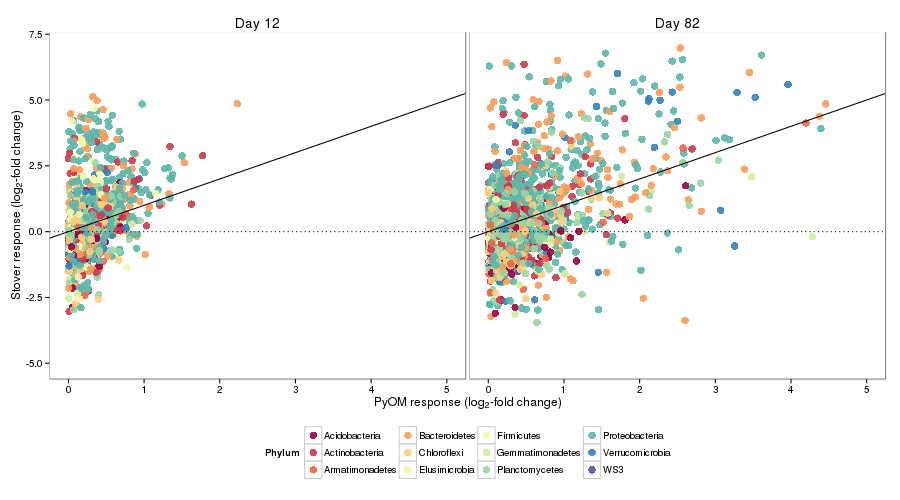

In [20]:
%%R -h 500 -w 900
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.plot

sums<-ddply(D,"Phylum",summarize,sum=length(Phylum))
remove<-sums$Phylum[sums$sum<=mintaxa]
D2<-D[!(D$Phylum %in% remove),]
D2$Phylum<-factor(D2$Phylum)
# Removing the rare phyla

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=Phylum))
p = p + geom_point(size=3.5, alpha=0.9)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~DayName, ncol=2)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-5, 7))
p = p + theme_bw() +
  theme(
    plot.background = element_rect(fill = "transparent", colour = NA)
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,panel.background = element_rect(fill = "transparent",colour = NA)
  ) +
  theme(legend.position="bottom", strip.text.x = element_text(size=14), 
        strip.background = element_rect(colour="white", fill="white"))
p = p + guides(colour = guide_legend("Phylum", nrow=3))
               #shape = guide_legend("Days since addition"))
p = p + labs(x=expression(paste("PyOM response (", log[2],"-fold change)",sep="")), y=expression(paste("Stover response (", log[2],"-fold change)",sep="")))


colourCount = length(unique(D2$Phylum))
getPalette = colorRampPalette(brewer.pal(14, "Spectral"))
p = p + scale_colour_manual(values=getPalette(colourCount))

#ggsave(filename = "Log2FullPhyla.pdf", plot = p, width=8, height = 5.5)

p

### grey points

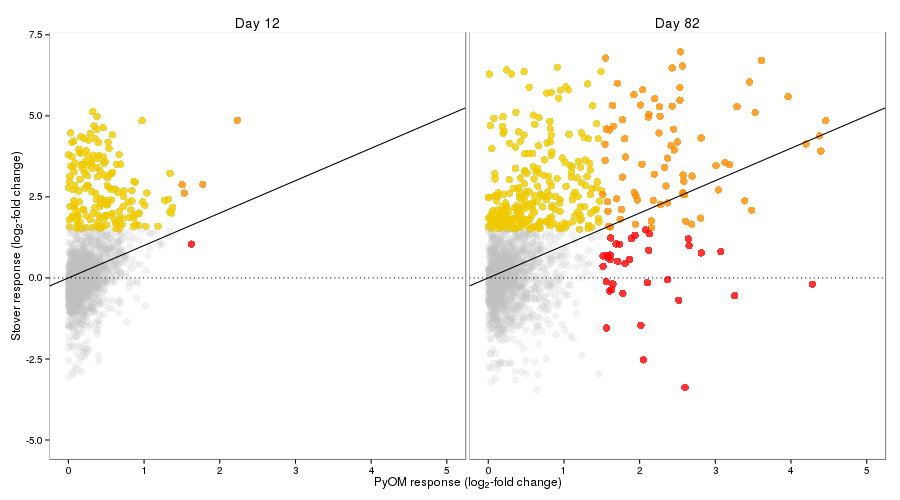

In [120]:
%%R -h 500 -w 900
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.plot

PyOMcutoff = 1.5
Stovercutoff = 1.5
Radialcutoff = 1.5

D = D %>%
    dplyr::mutate(RadialResponse=(PyOM^2+Stover^2)^0.5)%>%
    #dplyr::mutate(PointAlpha=ifelse(RadialResponse>=Radialcutoff, 1 ,0))%>%
    dplyr::mutate(PointAlpha=ifelse(PyOM>=PyOMcutoff | Stover>=Stovercutoff,1,0))%>%
    dplyr::mutate(PointColour=ifelse(PyOM>=PyOMcutoff & Stover>=Stovercutoff,1, 
                                    ifelse(PyOM>PyOMcutoff,2,
                                    ifelse(Stover>Stovercutoff,3,0))))

D$PointColour=as.factor(D$PointColour)

sums<-ddply(D,"Phylum",summarize,sum=length(Phylum))
remove<-sums$Phylum[sums$sum<=mintaxa]
D2<-D[!(D$Phylum %in% remove),]
D2$Phylum<-factor(D2$Phylum)
# Removing the rare phyla

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, colour=PointColour, alpha=PointAlpha))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)

p = p + facet_wrap(~DayName, ncol=2)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-5, 7))
p = p + theme_bw() +
  theme(
    plot.background = element_rect(fill = "transparent", colour = NA)
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,panel.background = element_rect(fill = "transparent",colour = NA)
  ) +
  theme(legend.position="bottom", strip.text.x = element_text(size=14), 
        strip.background = element_rect(colour="white", fill="white"))
p = p + labs(x=expression(paste("PyOM response (", log[2],"-fold change)",sep="")), y=expression(paste("Stover response (", log[2],"-fold change)",sep="")))

p = p + scale_colour_manual(values=c("grey","darkorange","red","gold2"), guide="none")
p = p + scale_alpha_continuous(range = c(0.2, 0.8), guide = "none")

ggsave(filename = "Log2FullPhylaShaded.pdf", plot = p, width=8, height = 4.5)

p

### Making KDRs

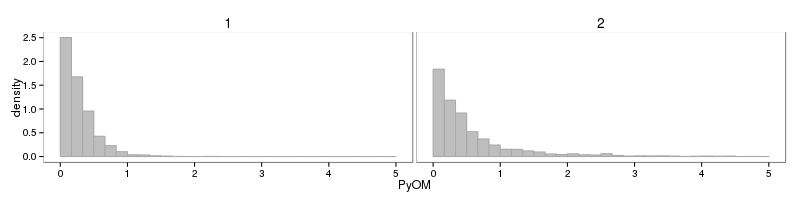

In [140]:
%%R -h 200 -w 800
p = ggplot(D2, aes(x = PyOM))
p = p + geom_histogram(aes(y=..density..), fill="grey", colour = "darkgrey")
p = p + facet_wrap(~Day)
p = p + xlim(0,5)
p = p + theme_bw() +
  theme(
    plot.background = element_rect(fill = "transparent", colour = NA)
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,panel.background = element_rect(fill = "transparent",colour = NA)
  ) +
  theme(legend.position="bottom", strip.text.x = element_text(size=14), 
        strip.background = element_rect(colour="white", fill="white"))
ggsave(filename = "KDRPyOM.pdf", plot = p, width=8, height = 2)
p

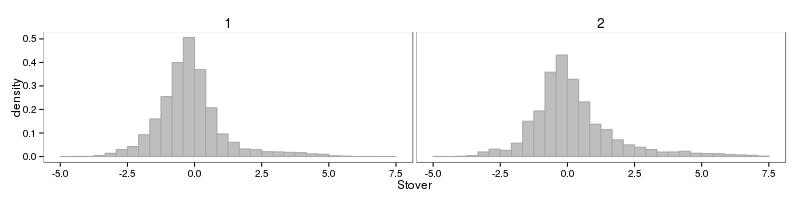

In [141]:
%%R -h 200 -w 800
p = ggplot(D2, aes(x = Stover))
p = p + geom_histogram(aes(y=..density..), fill="grey", colour = "darkgrey")
p = p + facet_wrap(~Day)
p = p + xlim(-5,7.5)
p = p + theme_bw() +
  theme(
    plot.background = element_rect(fill = "transparent", colour = NA)
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,panel.background = element_rect(fill = "transparent",colour = NA)
  ) +
  theme(legend.position="bottom", strip.text.x = element_text(size=14), 
        strip.background = element_rect(colour="white", fill="white"))
ggsave(filename = "KDRStover.pdf", plot = p, width=8, height = 2)
p

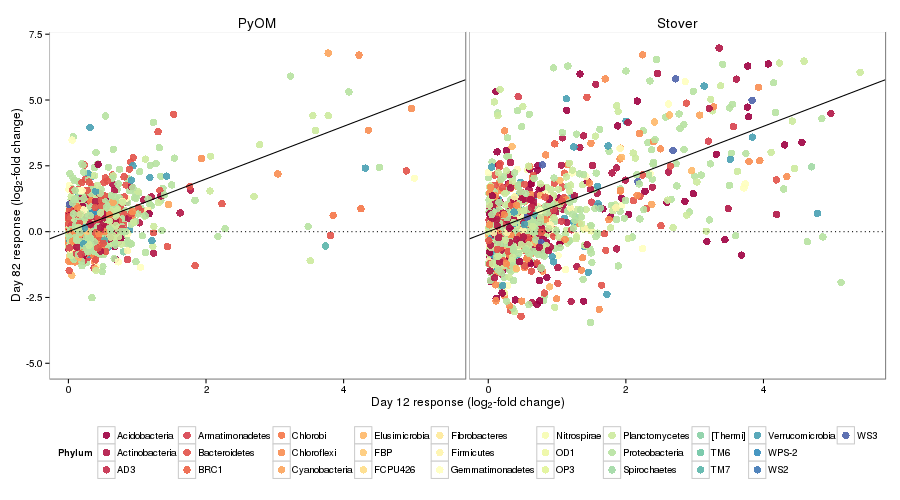

In [18]:
%%R -h 500 -w 900
#p = ggplot(d.plot, aes(x = `1`, y =`2`))

D <- d.day

sums<-ddply(D,"Phylum",summarize,sum=length(Phylum))
remove<-sums$Phylum[sums$sum<=mintaxa]
D2<-D[!(D$Phylum %in% remove),]
D2$Phylum<-factor(D2$Phylum)
# Removing the rare phyla

D2$AmdmtName = ifelse(D2$Amdmt==1,"PyOM","Stover")
p = ggplot(D2, aes(x = D2[,9], y = D2[,10], color=Phylum))
p = p + geom_point(size=3.5, alpha=0.9)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~AmdmtName, ncol=2)
p = p + scale_x_continuous(limits = c(0, 5.5)) + scale_y_continuous(limits = c(-5, 7))
p = p + theme_bw() +
  theme(
    plot.background = element_rect(fill = "transparent", colour = NA)
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,panel.background = element_rect(fill = "transparent",colour = NA)
  ) +
  theme(legend.position="bottom", strip.text.x = element_text(size=14), 
        strip.background = element_rect(colour="white", fill="white"))
p = p + guides(colour = guide_legend("Phylum", nrow=3))
               #shape = guide_legend("Days since addition"))
p = p + labs(x=expression(paste("Day 12 response (", log[2],"-fold change)",sep="")), y=expression(paste("Day 82 response (", log[2],"-fold change)",sep="")))


colourCount = length(unique(D2$Phylum))
getPalette = colorRampPalette(brewer.pal(14, "Spectral"))
p = p + scale_colour_manual(values=getPalette(colourCount))

#ggsave(filename = "Log2FullPhyla.pdf", plot = p, width=8, height = 5.5)

p

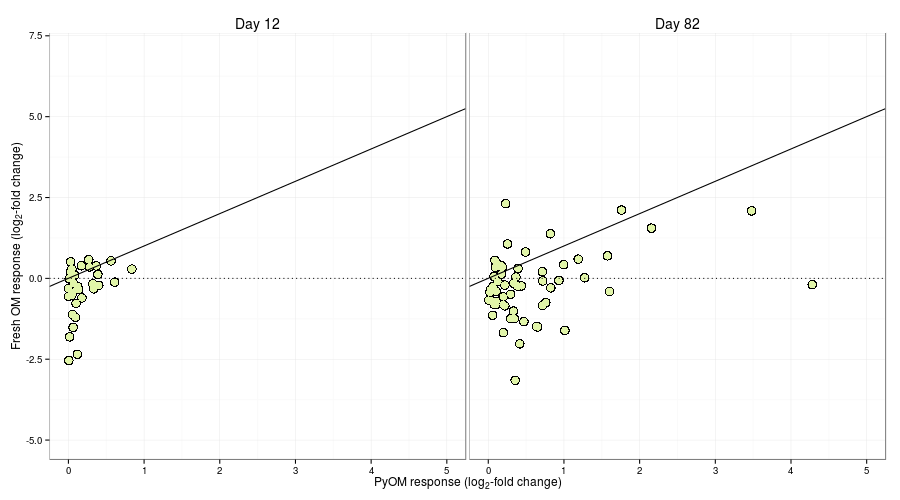

In [126]:
%%R -h 500 -w 900
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.plot

keep<-"Gemmatimonadetes"
D2<-D[(D$Phylum %in% keep),]
D2$Phylum<-factor(D2$Phylum)
# Selecting the phylum


sums<-ddply(D2,"Phylum",summarize,sum=length(Phylum))
remove<-sums$Phylum[sums$sum<=mintaxa]
D2<-D2[!(D2$Phylum %in% remove),]
D2$Phylum<-factor(D2$Phylum)
# Removing the rare phyla

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=Phylum))
p = p + geom_point(size=4.5, colour="black") + geom_point(size=3.5, colour="#E1F5A9")
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~DayName, ncol=2)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-5, 7))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(legend.position="bottom", strip.text.x = element_text(size=14), 
        strip.background = element_rect(colour="white", fill="white"))
p = p + guides(colour = guide_legend("Phylum", nrow=3))
               #shape = guide_legend("Days since addition"))
p = p + labs(x=expression(paste("PyOM response (", log[2],"-fold change)",sep="")), y=expression(paste("Fresh OM response (", log[2],"-fold change)",sep="")))


#colourCount = 16
#getPalette = colorRampPalette(brewer.pal(11, "Spectral"))
#p = p + scale_colour_manual(values=getPalette(colourCount)[9])
ggsave(filename = "Log2Gem.pdf", plot = p, width=8, height = 4.9)
p

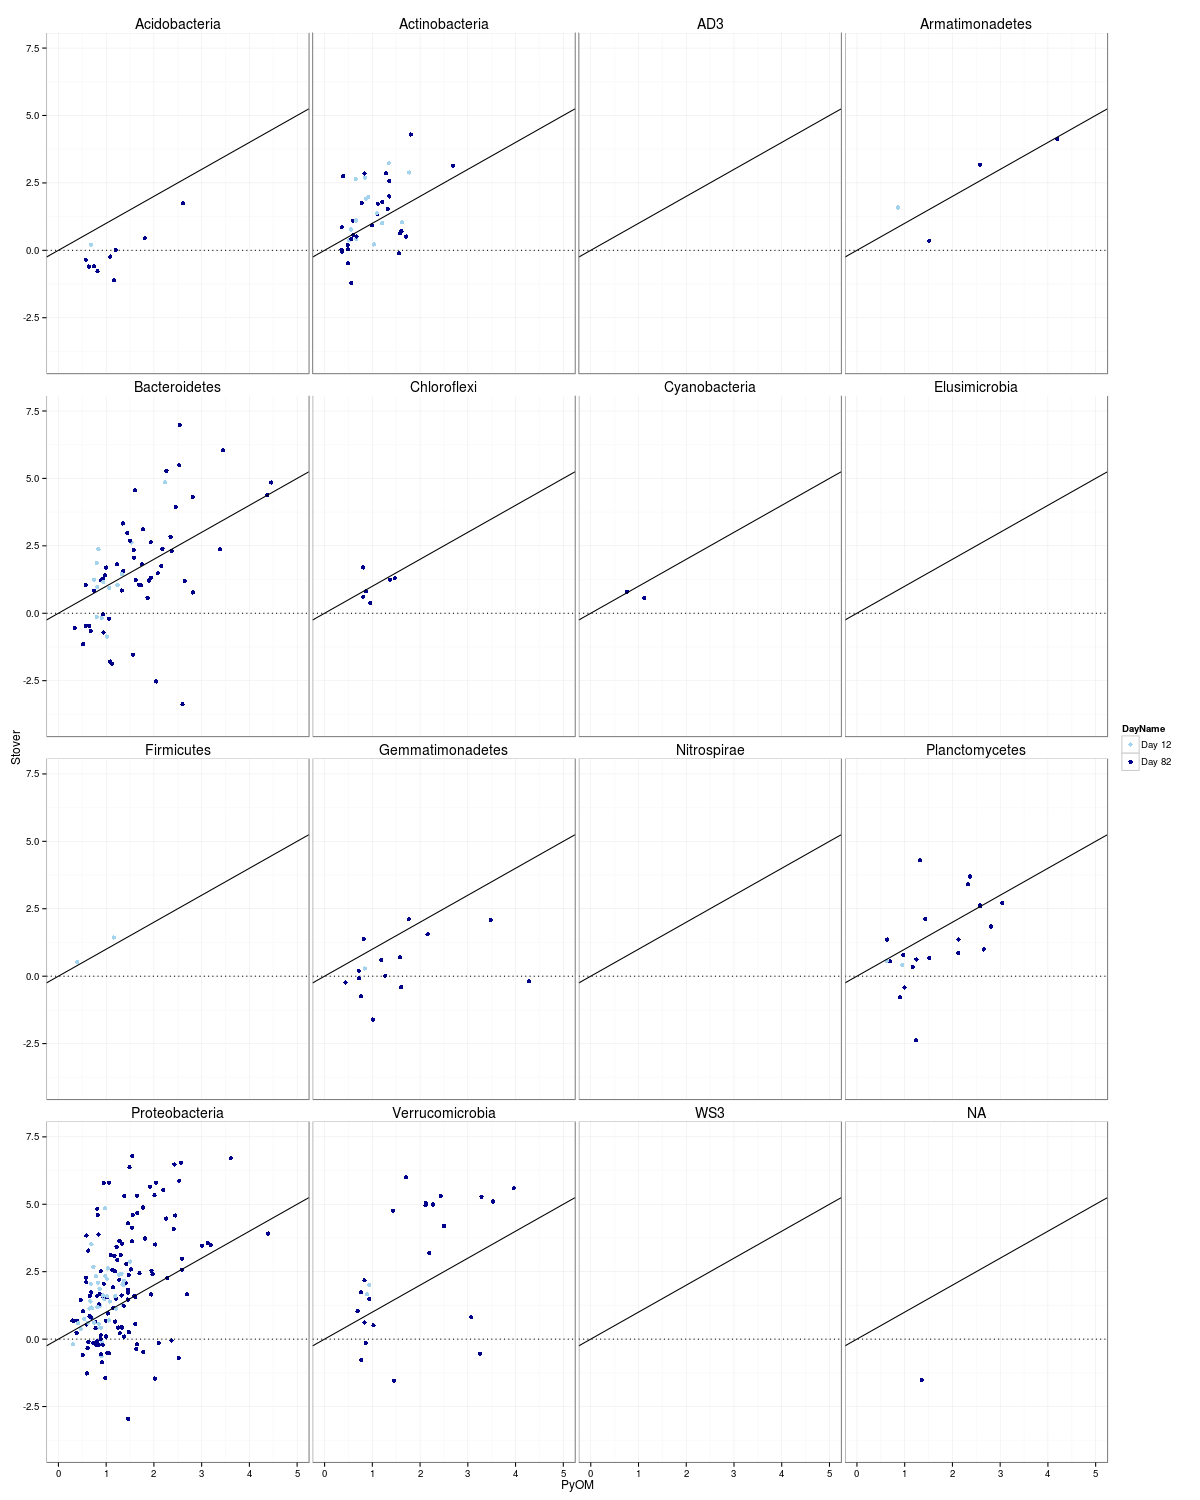

In [161]:
%%R -h 1500 -w 1200
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax

sums<-ddply(D,"taxonomy.Phylum",summarize,sum=length(taxonomy.Phylum))
remove<-sums$taxonomy.Phylum[sums$sum<=mintaxa]
D2<-D[!(D$taxonomy.Phylum %in% remove),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Removing the rare phyla

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=DayName))
p = p + geom_point()
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Phylum, ncol=4)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p = p + scale_color_manual(values=c("lightskyblue2","blue4"))
# "orange","gold1","red3"

p

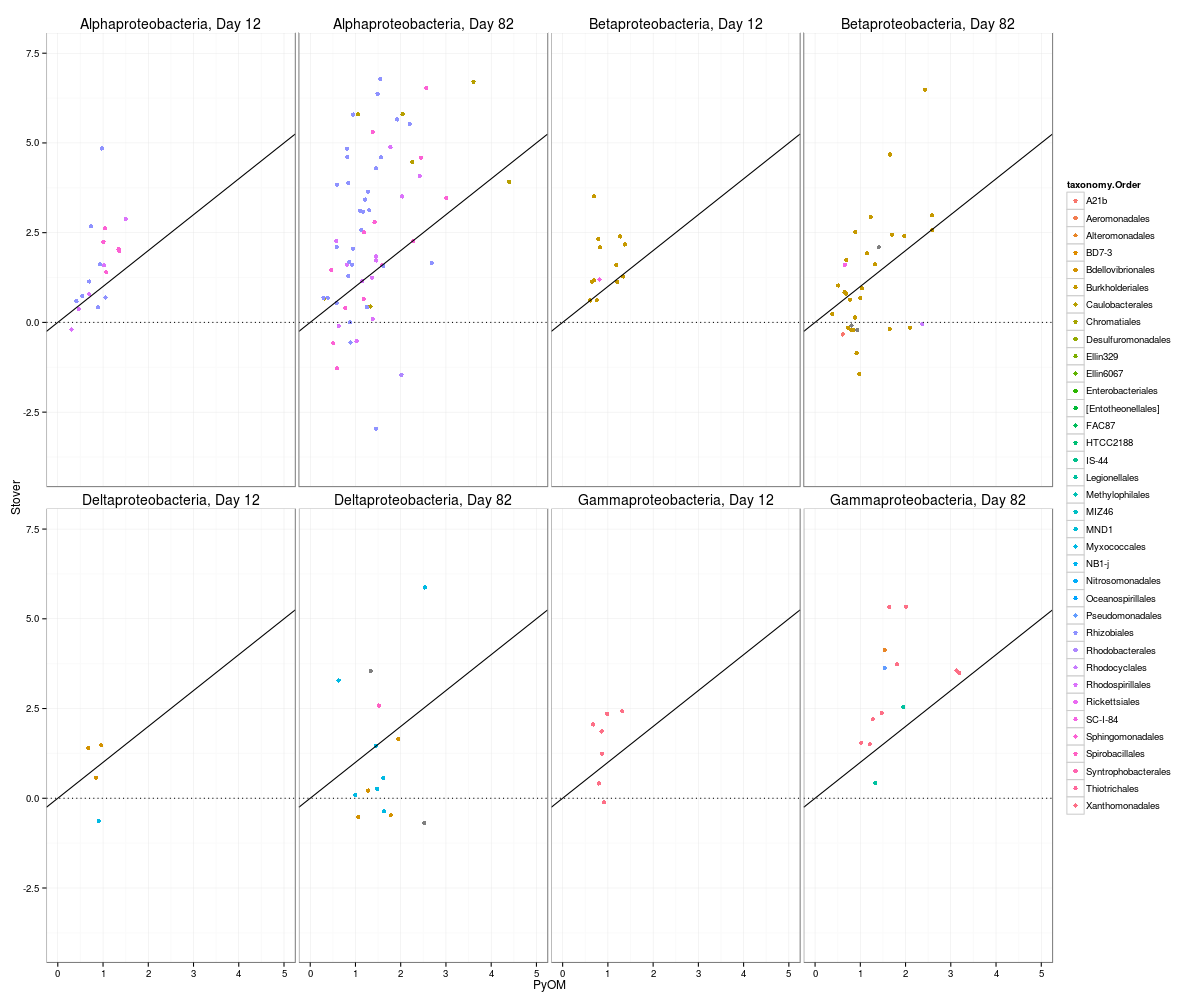

In [162]:
%%R -h 1000 -w 1200
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-"Proteobacteria"
D2<-D[(D$taxonomy.Phylum %in% keep),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Selecting the phylum

sums<-ddply(D2,"taxonomy.Class",summarize,sum=length(taxonomy.Class))
remove<-sums$taxonomy.Class[sums$sum<=mintaxa]
D2<-D2[!(D2$taxonomy.Class %in% remove),]
D2$taxonomy.Class<-factor(D2$taxonomy.Class)
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Order))
p = p + geom_point()
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Class~DayName, ncol=4)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p

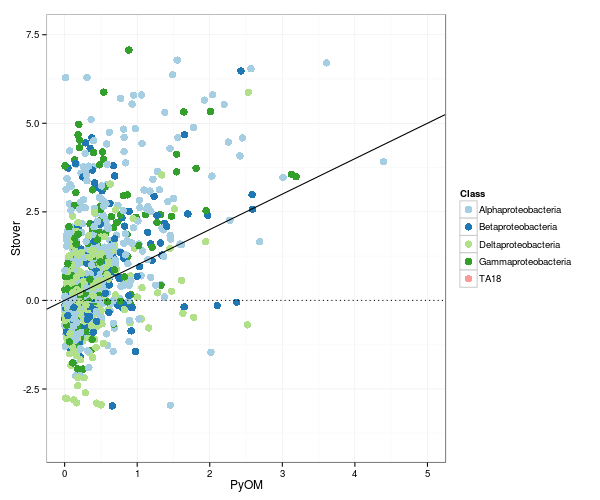

In [127]:
%%R -h 500 -w 600
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.plot
keep<-"Proteobacteria"
D2<-D[(D$Phylum %in% keep),]
D2$Phylum<-factor(D2$Phylum)
# Selecting the phylum


sums<-ddply(D2,"Class",summarize,sum=length(Class))
remove<-sums$Class[sums$sum<=mintaxa]
D2<-D2[!(D2$Class %in% remove),]
D2$Class<-factor(D2$Class)
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=Class))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
#p = p + facet_wrap(~taxonomy.Class~DayName, ncol=4)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p = p + scale_color_brewer(palette="Paired")
p

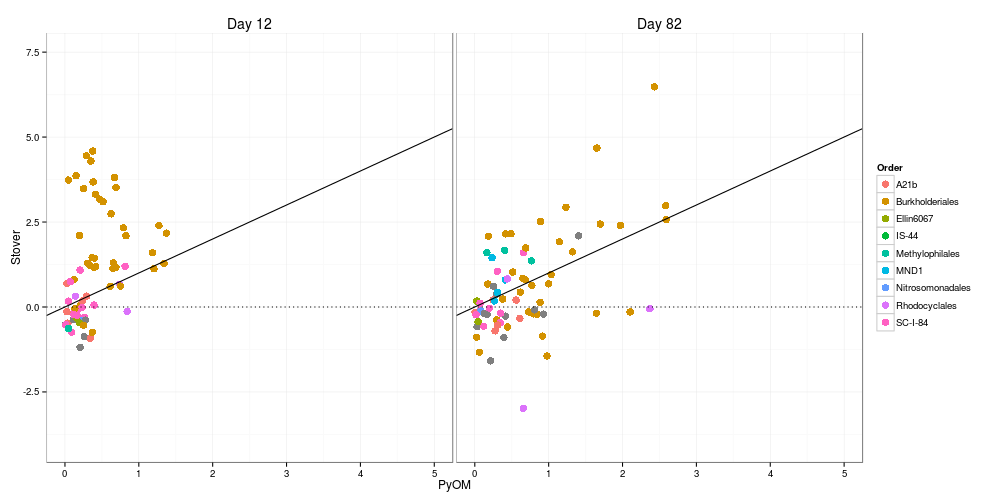

In [129]:
%%R -h 500 -w 1000
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.plot
keep<-"Proteobacteria"
D2<-D[(D$Phylum %in% keep),]
D2$Phylum<-factor(D2$Phylum)
# Selecting the phylum

D <- d.narm.tax
keep<-"Betaproteobacteria"
D2<-D[(D$Class %in% keep),]
D2$Class<-factor(D2$Class)
# Selecting the class

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=Order))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
p = p + facet_wrap(~DayName, ncol=2)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p

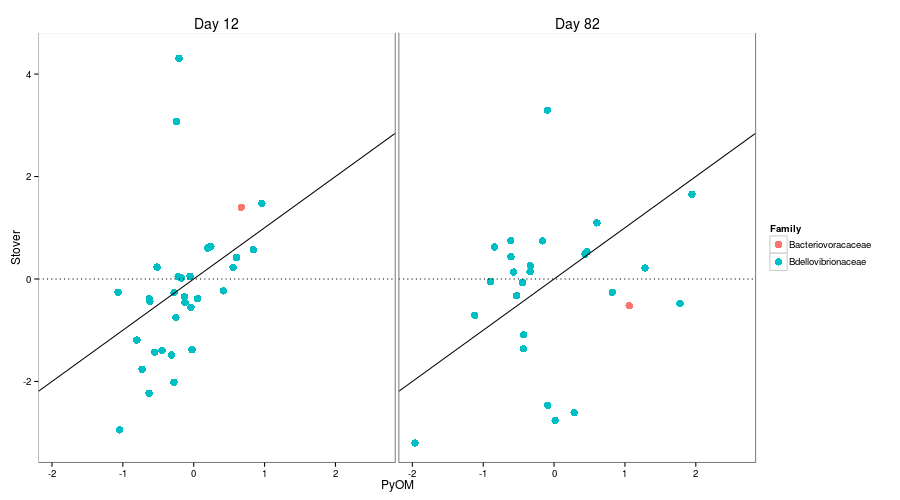

In [130]:
%%R -h 500 -w 900

D <- d.narm.tax
keep<-"Bdellovibrionales"
D2<-D[(D$Order %in% keep),]
D2$order<-factor(D2$Order)
# Selecting the phylum


D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=Family))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
p = p + facet_wrap(~DayName, ncol=2)
# p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p


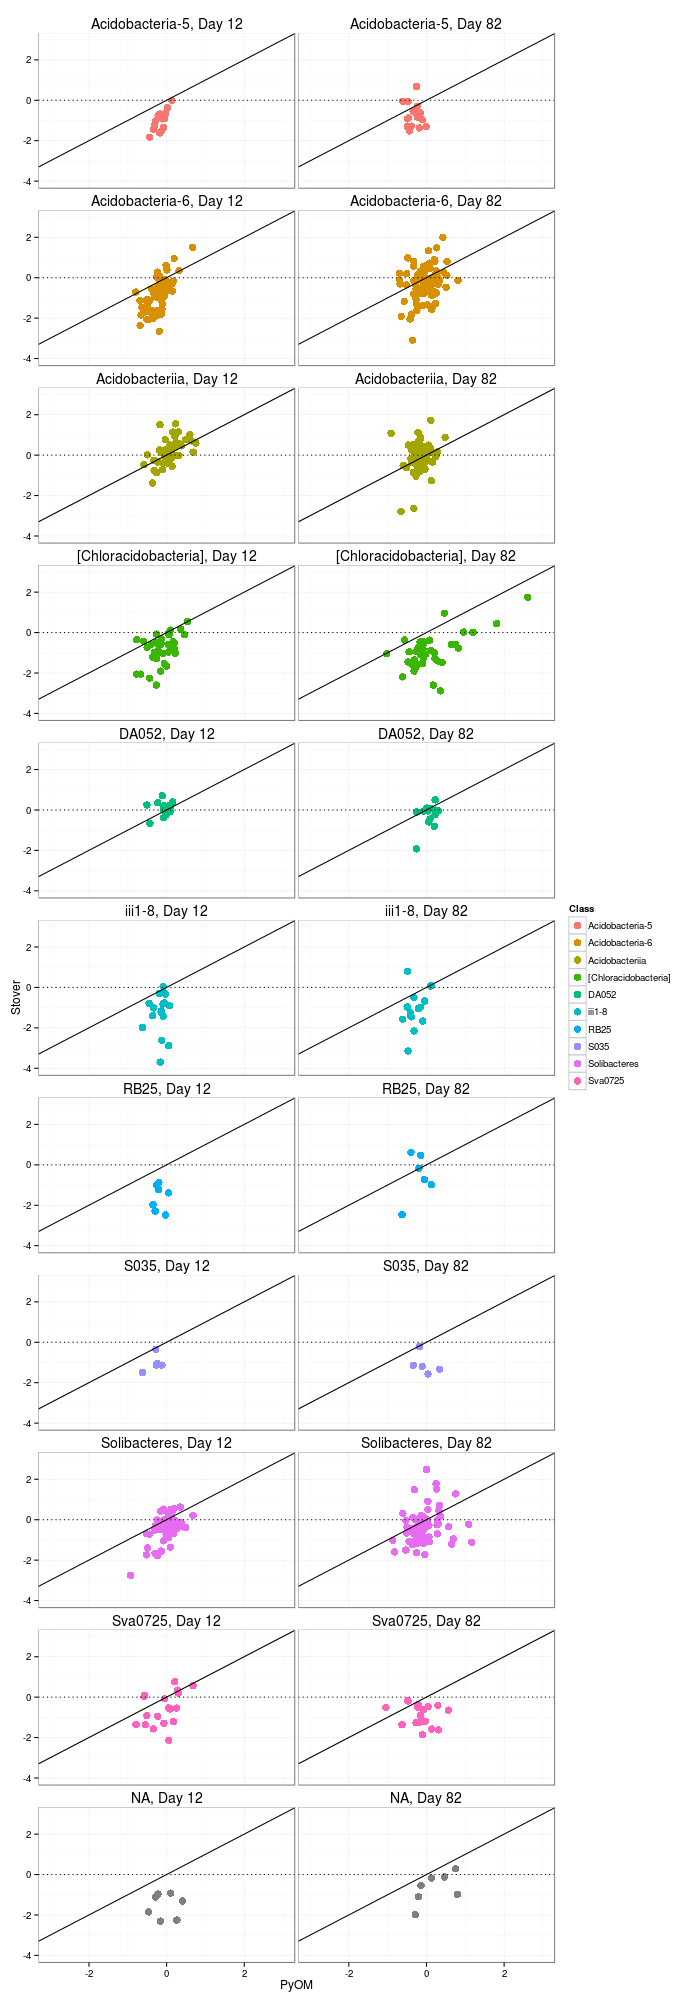

In [21]:
%%R -h 2000 -w 700
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
mintaxa = 10
D <- d.narm.tax
keep<-"Acidobacteria"
D2<-D[(D$Phylum %in% keep),]
D2$Phylum<-factor(D2$Phylum)
# Selecting the phylum


sums<-ddply(D2,"Order",summarize,sum=length(Class))
remove<-sums$Class[sums$sum<=mintaxa]
D2<-D2[!(D2$Class %in% remove),]
D2$Class<-factor(D2$Class)
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=Class))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~Class~DayName, ncol=2)
p = p + scale_x_continuous(limits = c(-3, 3)) + scale_y_continuous(limits = c(-4, 3))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p

Error in layout_base(data, vars, drop = drop) : 
  At least one layer must contain all variables used for facetting
In addition: There were 20 warnings (use warnings() to see them)


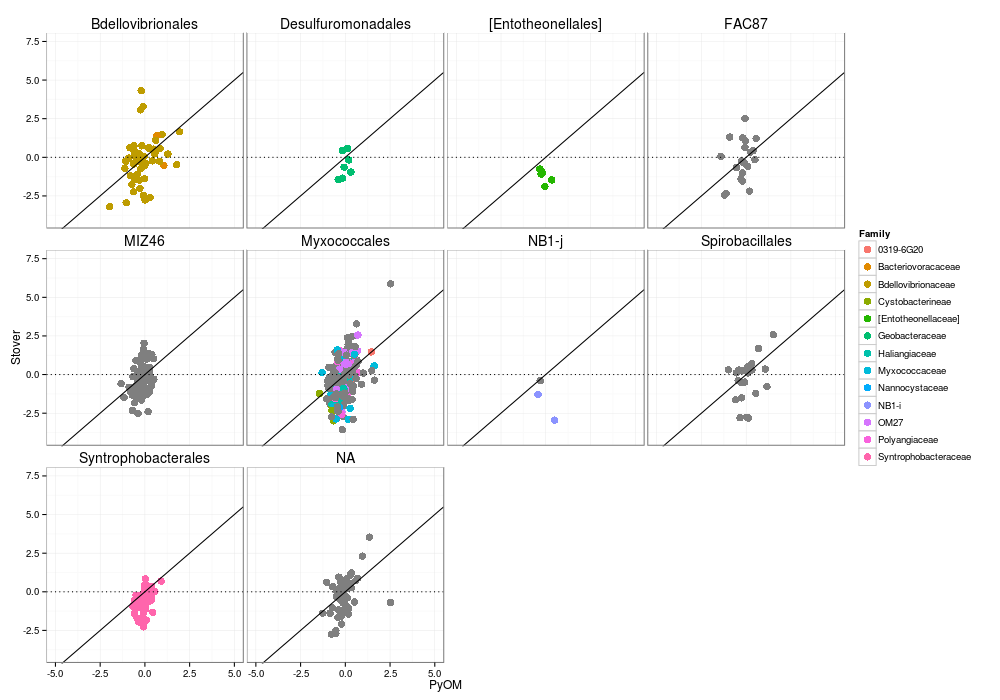

In [133]:
%%R -h 700 -w 1000
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.plot
keep<-"Deltaproteobacteria"
D2<-D[(D$Class %in% keep),]
D2$Class<-factor(D2$Class)
# Selecting the phylum


D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=Family))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~Order, ncol=4)
p = p + scale_x_continuous(limits = c(-5, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p

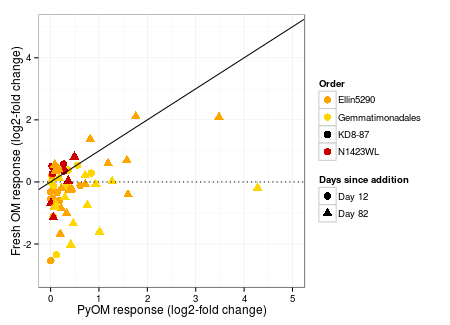

In [135]:
%%R -h 325 -w 450
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.plot
keep<-"Gemmatimonadetes"
D2<-D[(D$Phylum %in% keep),]
D2$Phylum<-factor(D2$Phylum)
# Selecting the phylum


sums<-ddply(D2,"Order",summarize,sum=length(Order))
remove<-sums$Order[sums$sum<=mintaxa]
D2<-D2[!(D2$Order %in% remove),]
D2$Order<-factor(D2$Order)
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=Order, shape=DayName))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
#p = p + facet_wrap(~taxonomy.Class~DayName, ncol=4)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-3, 5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p = p + scale_colour_manual(values=c("orange","gold1","black","red3"))
p = p + guides(colour = guide_legend("Order"), shape = guide_legend("Days since addition"))
p = p + labs(x="PyOM response (log2-fold change)", y="Fresh OM response (log2-fold change)")


ggsave(filename = "Gemmatimonadetes.pdf", plot = p, width=5, height = 3.5)
p

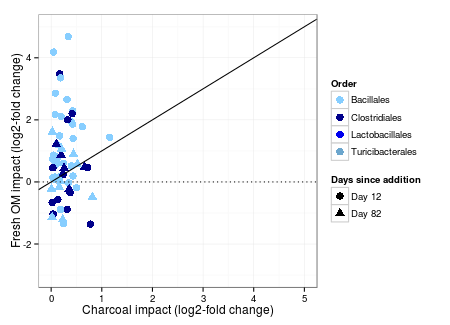

In [136]:
%%R -h 325 -w 450
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.plot
keep<-"Firmicutes"
D2<-D[(D$Phylum %in% keep),]
D2$Phylum<-factor(D2$Phylum)
# Selecting the phylum


sums<-ddply(D2,"Class",summarize,sum=length(Class))
remove<-sums$Class[sums$sum<=mintaxa]
D2<-D2[!(D2$Class %in% remove),]
D2$Class<-factor(D2$Class)
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=Order, shape=DayName))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
#p = p + facet_wrap(~taxonomy.Class~DayName, ncol=4)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-3, 5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p = p + scale_colour_manual(values=c("skyblue1","blue4","blue2","skyblue3"))
p = p + guides(colour = guide_legend("Order"), shape = guide_legend("Days since addition"))
p = p + labs(x="Charcoal impact (log2-fold change)", y="Fresh OM impact (log2-fold change)")

#ggsave(filename = "Firmicutes.pdf", plot = p, width=5, height = 3.5)
p

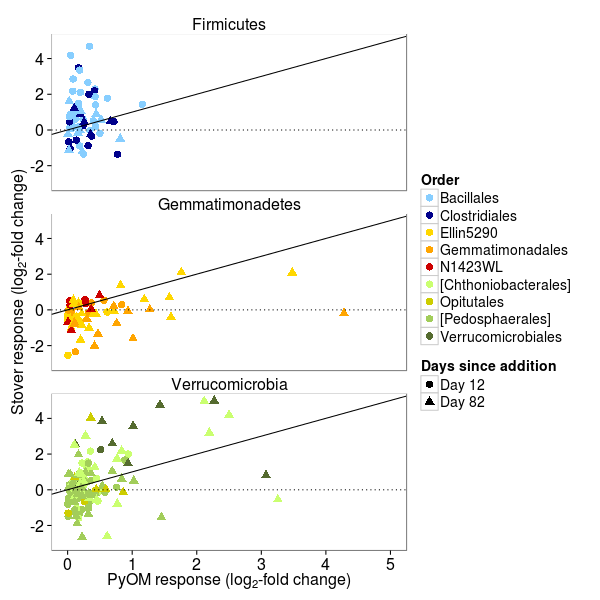

In [206]:
%%R -h 600 -w 600
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-c("Gemmatimonadetes","Firmicutes","Verrucomicrobia")
D2<-D[(D$Phylum %in% keep),]
D2$Phylum<-factor(D2$Phylum)
# Selecting the phylum

sums<-ddply(D2,"Order",summarize,sum=length(Order))
remove<-sums$Order[sums$sum<=mintaxa]
D2<-D2[!(D2$Order %in% remove),]
D2$Order<-factor(D2$Order, levels=c("Bacillales","Clostridiales","Ellin5290","Gemmatimonadales","N1423WL","[Chthoniobacterales]","Opitutales","[Pedosphaerales]","Verrucomicrobiales"))
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=Order, shape=DayName))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~Phylum, ncol=1)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-3, 5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.x = element_text(size = 16),
    axis.title.x = element_text(size = 16),
    axis.text.y = element_text(size=16),
    axis.title.y = element_text(size = 16),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 14)
  ) +
  theme(
      strip.text.x = element_text(size=16), 
      strip.background = element_rect(colour="white", fill="white")
  )

p = p + scale_colour_manual(values=c("skyblue1","blue4","gold1","orange","red3","darkolivegreen1","yellow3","darkolivegreen3","darkolivegreen"))
p = p + guides(colour = guide_legend("Order"), shape = guide_legend("Days since addition"))
p = p + labs(x=expression(paste("PyOM response (", log[2],"-fold change)",sep="")), y=expression(paste("Stover response (", log[2],"-fold change)",sep="")))

ggsave(filename = "Firm+Gemm+Verruc.pdf", plot = p, width=6, height = 8)
p

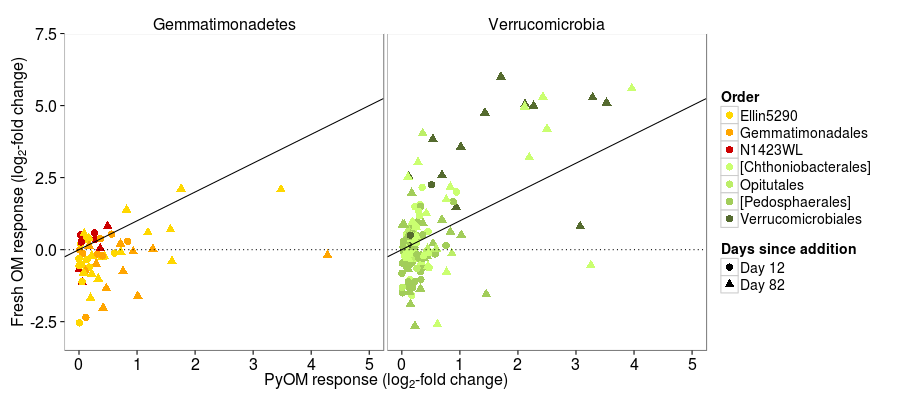

In [186]:
%%R -h 400 -w 900
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-c("Gemmatimonadetes","Verrucomicrobia")
D2<-D[(D$taxonomy.Phylum %in% keep),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Selecting the phylum


sums<-ddply(D2,"taxonomy.Order",summarize,sum=length(taxonomy.Order))
remove<-sums$taxonomy.Order[sums$sum<=mintaxa]
D2<-D2[!(D2$taxonomy.Order %in% remove),]
D2$taxonomy.Order<-factor(D2$taxonomy.Order, levels=c("Bacillales","Clostridiales","Ellin5290","Gemmatimonadales","N1423WL","[Chthoniobacterales]","Opitutales","[Pedosphaerales]","Verrucomicrobiales"))
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Order, shape=DayName))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Phylum, ncol=2)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-3, 7))
p = p + theme_bw() +
  theme(
    plot.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.x = element_text(size = 16),
    axis.title.x = element_text(size = 16),
    axis.text.y = element_text(size=16),
    axis.title.y = element_text(size = 16),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 14)
  ) +
  theme(
      strip.text.x = element_text(size=16), 
      strip.background = element_rect(colour="white", fill="white")
  )

p = p + scale_colour_manual(values=c("gold1","orange","red3","darkolivegreen1","darkolivegreen2","darkolivegreen3","darkolivegreen"))
p = p + guides(colour = guide_legend("Order"), shape = guide_legend("Days since addition"))
p = p + labs(x=expression(paste("PyOM response (", log[2],"-fold change)",sep="")), y=expression(paste("Fresh OM response (", log[2],"-fold change)",sep="")))

#ggsave(filename = "Firmicutes+Gemmatimonadetes.pdf", plot = p, width=11, height = 4.5)
p

In [56]:
%%R
D <- d.narm.tax
keep<-c("OTU.873")
D2<-D[(D$OTU %in% keep),]
D2

         OTU Day     PyOM    Stover     padjPyOM   padjStover        pprod
6767 OTU.873   1 2.231887  4.863171 8.052159e-08 5.601384e-07 4.510324e-14
6768 OTU.873   2 1.060160 -0.199297 4.702186e-03 8.759505e-01 4.118882e-03
     taxonomy.Kingdom taxonomy.Phylum taxonomy.Class taxonomy.Order
6767         Bacteria   Bacteroidetes     Cytophagia   Cytophagales
6768         Bacteria   Bacteroidetes     Cytophagia   Cytophagales
     taxonomy.Family taxonomy.Genus taxonomy.Species taxonomy.Rank1
6767   Cytophagaceae   Hymenobacter             <NA>           <NA>
6768   Cytophagaceae   Hymenobacter             <NA>           <NA>


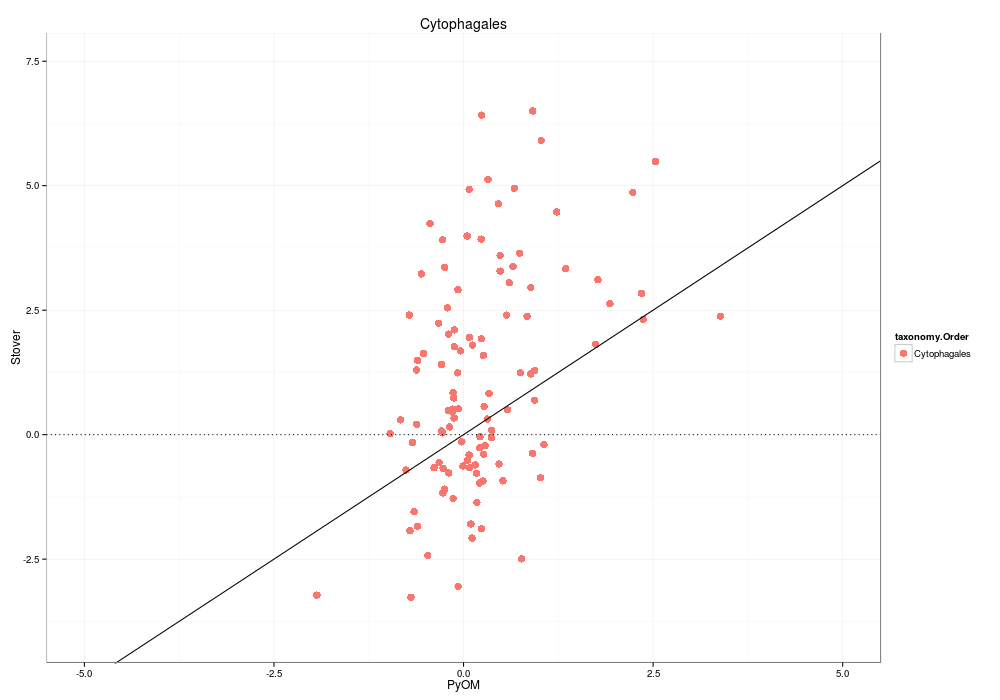

In [58]:
%%R -h 700 -w 1000
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-"Cytophagia"
D2<-D[(D$taxonomy.Class %in% keep),]
D2$taxonomy.Class<-factor(D2$taxonomy.Class)
# Selecting the phylum


D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Order))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Order, ncol=4)
p = p + scale_x_continuous(limits = c(-5, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p

In [182]:
%%R
D <- d.narm.tax
D.G<-D[D$taxonomy.Phylum=="Gemmatimonadetes",]
D.G=D.G[complete.cases(D.G$PyOM),]
D.G.2<-sort(D.G$PyOM, TRUE)[c(1,2)]
D.G[as.numeric(D.G$PyOM)==D.G.2,]
#Finds highest OTU

         OTU Day    PyOM     Stover     padjPyOM  padjStover        pprod
4822 OTU.542   2 4.28065 -0.1921791 1.654930e-21 0.949867764 1.571964e-21
6875 OTU.909   2 3.47943  2.0878837 1.648849e-38 0.000165742 2.732835e-42
     taxonomy.Kingdom  taxonomy.Phylum   taxonomy.Class   taxonomy.Order
4822         Bacteria Gemmatimonadetes Gemmatimonadetes Gemmatimonadales
6875         Bacteria Gemmatimonadetes Gemmatimonadetes        Ellin5290
       taxonomy.Family taxonomy.Genus taxonomy.Species taxonomy.Rank1
4822 Gemmatimonadaceae   Gemmatimonas             <NA>           <NA>
6875              <NA>           <NA>             <NA>           <NA>


In [201]:
%%R
D <- d.narm.tax
D.V<-D[D$taxonomy.Phylum=="Verrucomicrobia",]
D.V=D.V[complete.cases(D.V$PyOM),]
D.V.two<-sort(D.V$PyOM, TRUE)[4]
D.V[D.V$PyOM== D.V.two,]
# FOund at 5 and 4 rank (others are high stover response too)

         OTU Day     PyOM    Stover     padjPyOM padjStover       pprod
4369 OTU.456   2 3.256295 -0.543798 6.234275e-29  0.6861841 4.27786e-29
     taxonomy.Kingdom taxonomy.Phylum   taxonomy.Class       taxonomy.Order
4369         Bacteria Verrucomicrobia [Spartobacteria] [Chthoniobacterales]
           taxonomy.Family taxonomy.Genus taxonomy.Species taxonomy.Rank1
4369 [Chthoniobacteraceae]           <NA>             <NA>           <NA>
